# Approval Time Modeling
The goal of this project is to use procurement transaction data to predict the amount of time a order will take to be approved by a Supply Chain buyer. Buyers manage transactions for UCSF departments that need to be vetted for federal regulations. Typically, a department submits an requisition through an online system which routes it to a Supply Chain buyer who reviews the necessary purchasing requirements and approves the order once the purchasing requirements are met.

### Import Modules

In [1]:
import pandas as pd
import numpy as np
import datetime
from datetime import timedelta
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
# Warnings have been checked and are false positives
pd.set_option('mode.chained_assignment', None)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
import statsmodels.api as sm
from scipy import stats
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams["font.family"] = "Arial"
font = {'size'   : 13}
plt.rc('font', **font)

## Data Processing and Feature Selection
First, let's take a look at what data we have to work with and features that we can use to create a model. I will have to avoid printing data set samples because there are names, addresses, and contact information present, but I will show the available fields. The data sets are structured as follows:

**Approvals:** Each row is a single step of the approval process labeled with a requisition number. A single requisition will have multiple rows of approval steps.

**Transactions:** Each row is a single line item in a requisition labeled with a requisition number. For example, if a chair and pen are a part of the same order, they would each have their own row in the data, but the same requisition number.

In order to join the data, we will need to aggregate the requisitions based on their requisition numbers(labeled as PR ID) to force uniqueness.

In [2]:
# Two years of approval data
ReqApproval = pd.read_csv(r'C:\Users\kpanfilov\Documents\Procurement Metrics\Data\PRApprovalHistory_Buyer Reqs 5-1-17 through 4-30-19.csv',encoding='latin1',low_memory=False,thousands=',')
# Two years of transactional data
ReqForm = pd.read_csv(r'C:\Users\kpanfilov\Documents\Procurement Metrics\Data\PRData_Buyer Reqs 5-1-17 through 4-30-19.csv',encoding='latin1',low_memory=False,thousands=',')

# List all available fields
list(ReqApproval)
list(ReqForm)

['PR ID',
 'External PR #',
 'PR Name',
 'PR Date',
 'Buyer:  username',
 'Buyer: First Name',
 'Buyer: Last Name',
 'Buyer: Email',
 'Home Department',
 'Workflow Step Name',
 'Workflow Step Date',
 'Workflow Step Action',
 'Approver: Username',
 'Approver: First Name',
 'Approver: Last Name',
 'Approver: Email',
 'Approver: Home Department']

['PR ID',
 'External PR #',
 'PR Name',
 'PR Date',
 'Workflow Folder/Step Name',
 'Approver/Assignee Name',
 'Description',
 'Supplier ID',
 'Supplier Name',
 'Supplier Number',
 'Supplier Preference',
 'Suppl-Cust Acct #',
 'PR Line ID',
 'PR Line #',
 'Consolidated Line Flag',
 'Item Type',
 'Spot Buy Flag',
 'Form Type',
 'SKU/Catalog #',
 'Product Description',
 'Manufacturer',
 'Mfr Catalog #',
 'Amount/UOM & UOM',
 'Product Size',
 'Category Preference',
 'Category Level 1',
 'Category Level 2',
 'Category Level 3',
 'Category Level 4',
 'Category Level 5',
 'Category Name',
 'CAS #',
 'UNSPSC',
 'Commodity Code',
 'Radioactive',
 'Hazmat',
 'Controlled',
 'RadMinor',
 'Select Agent',
 'Toxin',
 'Recycled',
 'Green Product',
 'Green Product Description',
 'LEED Compliance Details',
 'Energy Star',
 'ProdFlag 10',
 'Quantity',
 'Unit Price',
 'Unit Price Date',
 'Extended Price',
 'List Price',
 'List Price Date',
 'Current - 1 Unit Price',
 'Current - 1 Unit Price Date',
 'Curre

After reviewing the files and values to understand their significance and selected a subset of features that seem relevant to approval times based on conversations with team members and the buyers who have the domain knowledge. For the sake of brevity, I will go over the features that were initially chosen by defining them and explaining the resoning for my selection.
* **Extended Price:** Order dollar amount. The monetary size of the order can have an impact on approval time because orders that break certain thresholds can be subject to a public bidding process or approval by a person who has higher authority to approve high dollar amounts.
* **Buyer:** Person who vets and approves orders. Each buyer is responsible for a different departments and it would be interesting to see if there is any significant difference in how buyers impact approval time.
* **Form Type:** The form that a department needs to submit to the buyer for the order. The name of the form is an indicator of the type of order. Some forms are more difficult to complete than others and can cause the order to take additional time to approve.
* **Requester:** The person who is submitting the order. Requesters can have a impact of the order based on their proficiency of providing the correct information to the buyer.
* **Time before department approval:** Before an order reaches the Supply Chain buyers, a department needs to approve the order for budgetary and other reasons. Sometimes, an order can circulate the department because it does not meet departmental requirements. It could be an issue for buyers to approve an order that has already needed multiple revisions.
* **Approval Time:** The amount of time it takes for a buyer to approve an order once it is recieved from the department. This will be our label data.

Now that we have the features we are looking to create, the data needs to be processed.

In [3]:
# Combine first name and last name columns for unique names
ReqApproval['Buyer'] = ReqApproval['Approver: First Name'] + ' ' + ReqApproval['Approver: Last Name']
ReqForm['Requester'] = ReqForm['Buyer: First Name'] + ' ' + ReqForm['Buyer: Last Name']

# The 'Central Buyer' rows have the date that the buyer approved the requisition
Index = list(ReqApproval.loc[ReqApproval['Workflow Step Name'] == 'Central Buyer'].index.values)
# Keep all the 'Central Buyer' rows and the rows that have the department approval date
GetTime = ReqApproval.loc[ReqApproval.index.isin(Index) |
                         ReqApproval.index.isin([x+1 for x in Index]),
                          ['PR ID','Workflow Step Date','Workflow Step Name','Buyer']]
# Use the difference between the department approval date and buyer approval date to find the time to approval
GetTime['Approval Time P'] = np.nan
GetTime['Workflow Step Date'] = pd.to_datetime(GetTime['Workflow Step Date'])
GetTime['Approval Time P'] = GetTime['Workflow Step Date'].diff(periods=-1)
# Save the date that the buyer recieved the order
GetTime['Date Recieved'] = GetTime['Workflow Step Date'] - GetTime['Approval Time P']
GetTime = GetTime.loc[GetTime['Workflow Step Name'] == 'Central Buyer'].drop(columns='Workflow Step Name')
GetTime['Approval Time'] = ((GetTime['Approval Time P'].dt.days * 24) + (GetTime['Approval Time P'].dt.seconds / 3600)) / 24

# Modify data types for joining and aggregation
ReqForm['Extended Price'] = ReqForm['Extended Price'].astype(float)
ReqForm['Form Type'] = ReqForm['Form Type'].astype(str)
ReqForm['Product Description'] = ReqForm['Product Description'].astype(str)
ReqForm['PR Date'] = pd.to_datetime(ReqForm['PR Date'])

# Group by requisition ID to create a unique ID, then join the two data sets
GetTime = GetTime.merge(ReqForm.groupby('PR ID').agg({'PR Date':min,'Product Description':min,'Form Type':min,'Extended Price':sum,'Requester':min}).reset_index(), on='PR ID')

# Rename the 'Form Type' field values to clearly indicate the form that was used for the transaction
GetTime.loc[(GetTime['Form Type']=='Service') & (GetTime['Product Description']=='Professional Services/Independent Consulting Form'), 'Form Type'] = 'Professional Services/Independent Consulting'
GetTime.loc[(GetTime['Form Type']=='Service') & (GetTime['Product Description']!='Professional Services/Independent Consulting Form'), 'Form Type'] = 'Amount-based PO'
GetTime.loc[(GetTime['Form Type']=='WF_AlwaysBuyerApproval_CM') & (GetTime['Product Description']=='Facility Rental'), 'Form Type'] = 'Facility Rental'
GetTime.loc[(GetTime['Form Type']=='WF_AlwaysBuyerApproval_CM') & (GetTime['Product Description']!='Facility Rental'), 'Form Type'] = 'Relocation/Household Moves'
GetTime.loc[GetTime['Form Type']=='NonCatalogCustForm', 'Form Type'] = 'Non Catalog'
GetTime.loc[GetTime['Form Type']=='~PDPR~NoDis~AINV~PI_ATF2', 'Form Type'] = 'After the Fact'
GetTime.loc[GetTime['Form Type']=='WF_AlwaysBuyerApproval', 'Form Type'] = 'Software and Cloud Computing'
GetTime.loc[GetTime['Form Type']=='CapitalExpense', 'Form Type'] = 'Equipment Lease/Loan/Purchase'
GetTime.loc[GetTime['Form Type'].isin(['~PDPR~SBUY~NoDis~AINV~SPI~SW_R','~PDPR~SBUY~NoDis~AINV~SPI~SW_P','~PDPR~SBUY~NoDis~AINV~SPI~SW_T']), 'Form Type'] = 'Payment Request'
GetTime.loc[GetTime['Form Type']=='AmountBasedContract~SBUY', 'Form Type'] = 'Amount-based Contract Required'
GetTime.loc[GetTime['Form Type']=='Controlled Substance', 'Form Type'] = 'Controlled Substance'
GetTime.loc[GetTime['Form Type'].isin(['~PDPR~SBUY~NoDis~AINV~SPI~SW_C','~PDPR~SBUY~NoDis~AINV~SPI~SW_N']), 'Form Type'] = 'Payment Request'
GetTime.loc[GetTime['Form Type']=='~SBUY~NoDis~AINV~SPI~SW_M', 'Form Type'] = 'Meeting and Entertainment Payment Request'
GetTime.loc[GetTime['Form Type']=='MiniForm~SBUY', 'Form Type'] = 'Mini Form'
GetTime.loc[GetTime['Form Type']=='NonCatContract~SBUY', 'Form Type'] = 'Non-Catalog Contract Required'
GetTime.loc[GetTime['Form Type']=='OpsReview~SBUY', 'Form Type'] = 'Outbound Freight'
GetTime.loc[GetTime['Form Type']=='StandingOrder_Amt', 'Form Type'] = 'Standing Order Amount Based'
GetTime.loc[GetTime['Form Type']=='~NoDis~SBUY_Surplus', 'Form Type'] = 'Surplus'
GetTime.loc[GetTime['Form Type']=='nan','Form Type'] = 'Catalog'
GetTime = GetTime.loc[(GetTime['Form Type']!='~PDPR~NoPO~SBUY_ChangeOrder')]

# Narrow down the columns
CDF = GetTime[['PR ID','PR Date','Workflow Step Date','Buyer','Approval Time','Date Recieved','Form Type','Extended Price','Requester']]

# Calculate time before department approval
CDF['Time before Dept Approval'] = CDF['Date Recieved'] - CDF['PR Date']
Reqs = list(CDF.loc[CDF['Time before Dept Approval'].dt.total_seconds() < 0,'PR ID'])

# Remove the duplicate requisitions records due to requisitions that were returned and resubmitted
CDF = CDF.drop_duplicates(subset='PR ID',keep='last')

# Manual input to fix resubmitted requisition data
# Time calculated using BearBuy requisition history: First req assigned date to first central buyer assigned date
CDF.loc[(CDF['PR ID'] == 106953153), 'Time before Dept Approval'] = datetime.timedelta(days=8)
CDF.loc[(CDF['PR ID'] == 108431458), 'Time before Dept Approval'] = datetime.timedelta(days=6)
CDF.loc[(CDF['PR ID'] == 110868603), 'Time before Dept Approval'] = datetime.timedelta(days=4)
CDF.loc[(CDF['PR ID'] == 112401731), 'Time before Dept Approval'] = datetime.timedelta(days=0)
CDF.loc[(CDF['PR ID'] == 112567519), 'Time before Dept Approval'] = datetime.timedelta(days=1)
CDF.loc[(CDF['PR ID'] == 112676577), 'Time before Dept Approval'] = datetime.timedelta(days=5)
CDF.loc[(CDF['PR ID'] == 84079013), 'Time before Dept Approval'] = datetime.timedelta(days=0)
CDF.loc[(CDF['PR ID'] == 92878356), 'Time before Dept Approval'] = datetime.timedelta(days=0)
CDF.loc[(CDF['PR ID'] == 95914736), 'Time before Dept Approval'] = datetime.timedelta(days=0)
CDF.loc[(CDF['PR ID'] == 107319637), 'Time before Dept Approval'] = datetime.timedelta(days=0)
CDF.loc[(CDF['PR ID'] == 88994010), 'Time before Dept Approval'] = datetime.timedelta(days=5)
CDF.loc[(CDF['PR ID'] == 108294821), 'Time before Dept Approval'] = datetime.timedelta(days=1)
CDF.loc[(CDF['PR ID'] == 108384549), 'Time before Dept Approval'] = datetime.timedelta(days=0)
CDF.loc[(CDF['PR ID'] == 92451074), 'Time before Dept Approval'] = datetime.timedelta(days=0)
CDF.loc[(CDF['PR ID'] == 117223401), 'Time before Dept Approval'] = datetime.timedelta(days=0)
CDF.loc[(CDF['PR ID'] == 111936235), 'Time before Dept Approval'] = datetime.timedelta(days=3)
CDF.loc[(CDF['PR ID'] == 108097571), 'Time before Dept Approval'] = datetime.timedelta(days=0)
CDF.loc[(CDF['PR ID'] == 106360807), 'Time before Dept Approval'] = datetime.timedelta(days=1)
CDF.loc[(CDF['PR ID'] == 108570515), 'Time before Dept Approval'] = datetime.timedelta(days=1)
CDF.loc[(CDF['PR ID'] == 98955474), 'Time before Dept Approval'] = datetime.timedelta(days=1)
CDF.loc[(CDF['PR ID'] == 107256856), 'Time before Dept Approval'] = datetime.timedelta(days=0)

# Narrow columns again
Data = CDF[['PR ID','Form Type','Time before Dept Approval','Extended Price','Buyer','Approval Time','Requester']]
# Modify time metric to a numeric value
Data['Time before Dept Approval'] = Data['Time before Dept Approval'].dt.total_seconds() / 86400

The following section encodes the requester categorical column into a numeric value for processing. I go over the decision and reasoning to do so at the start of the "Model Testing" section below.

In [4]:
# Store the counts for each requester
ReqCount = Data['Requester'].value_counts()

# Create a column that stores the user's requisition count
Data['User'] = Data['Requester'].apply(lambda x: ReqCount[x])

# Remove the Requester column and PR ID column since they will not be used for modeling
Data = Data.drop(columns=['Requester','PR ID'])

# Preivew the result
Data.head()

,Form Type,Time before Dept Approval,Extended Price,Buyer,Approval Time,User
1,Amount-based PO,3.0,269753.27,Rosemarie Hughes,1.0,16
2,Facility Rental,1.0,1250992.00,Robert Puerzer,16.0,288
3,Equipment Lease/Loan/Purchase,0.0,929012.16,Byron Wilson,1.0,30
4,Amount-based PO,0.0,55000.00,Tyrone Webb,0.0,31
5,Professional Services/Independent Consulting,0.0,90000.00,Tyrone Webb,35.0,31


## Data Analysis

Here I examine my features to understand the data. Before we start to try to model the data and make predictions, I try to plot out a visualizations of the fields and how they relate to the output (Approval Time). This might give me some bearing on how to interpret the results of the models.

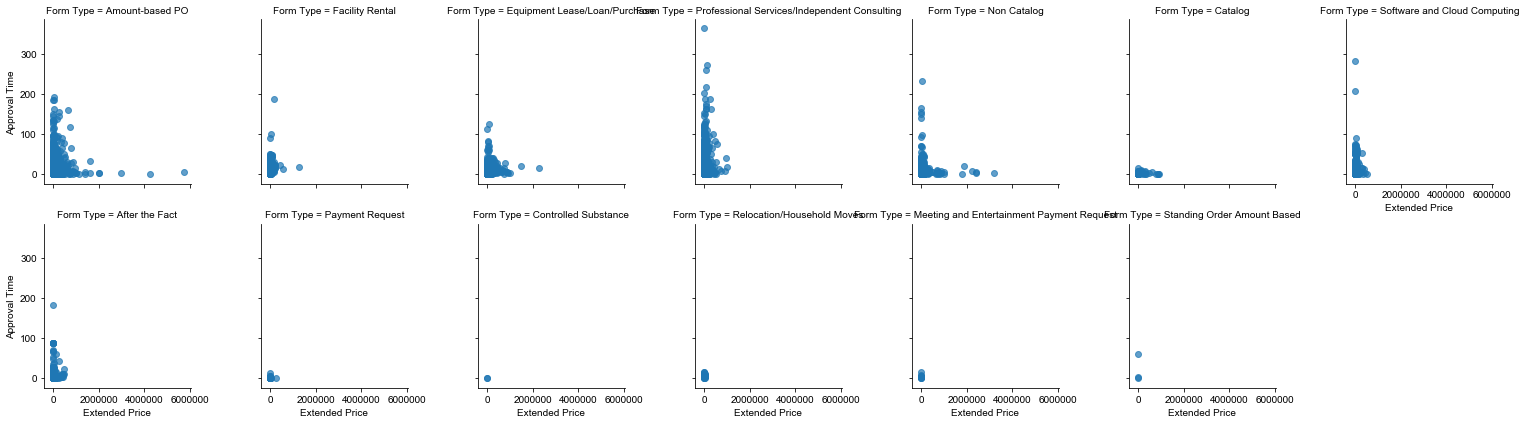

In [5]:
# Make a scatter plot for each Form Type showing the order amount vs. approval time
g = sns.FacetGrid(Data, col="Form Type", col_wrap=7)
g.map(plt.scatter, "Extended Price", "Approval Time", alpha=.7)
g.add_legend();

So far, it seems that the price of an order does not have much positive correlation to the time it takes to approve an order. What we can see from this is that the Professional Services form seems to have the largest spread in approval time regardless of price, and tends to take longer than others.

It is difficult to see exactly what is going on since many of the data points are positioned so closely together, so I try to adjust the axis to get a better view.

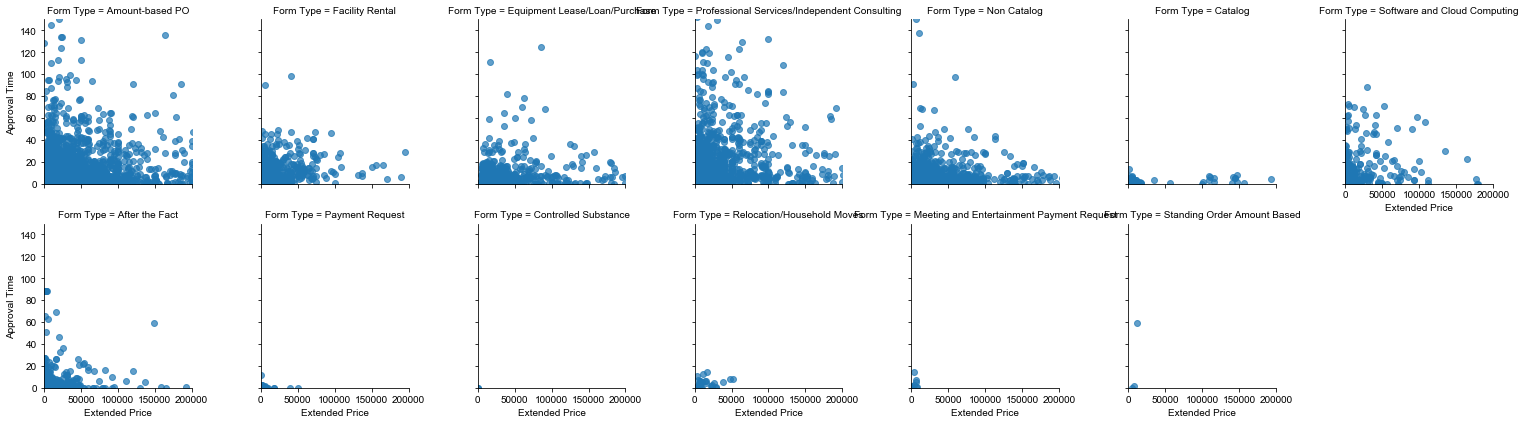

In [6]:
# Make a scatter plot for each Form Type showing the order amount vs. approval time
from matplotlib import pyplot
g = sns.FacetGrid(Data, col="Form Type", col_wrap=7, ylim=(0, 150), xlim=(0, 200000))
g.map(plt.scatter, "Extended Price", "Approval Time", alpha=.7)
g.add_legend();

After adjusting the scales, we can see that there are a large number cheap orders that do not take a lot of time. Some forms, such as Catalog and Relocations, seems to have relatively constant approval times. On the other hand, Amount-based purchase order and Professional services seem to have a larger spread of approval times.

Now, I took a look at how spending, time before approval, and user experience relate to approval times. It's difficult to visualize the data since the points are all clustered around lower values, but let's take a look to see if we can spot any interesting trends.

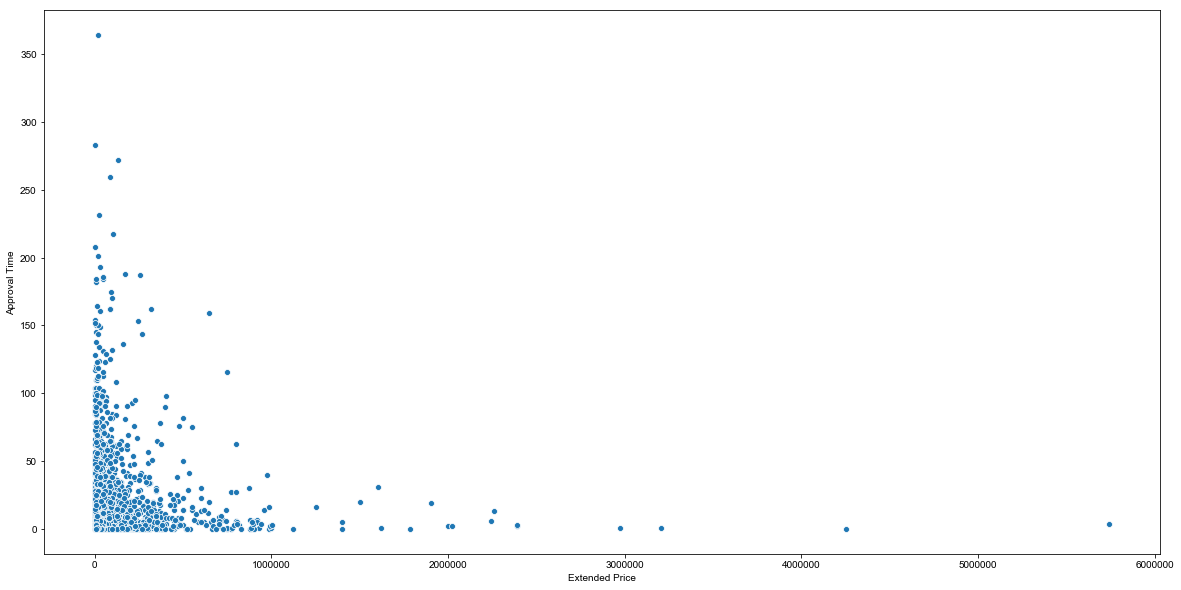

In [7]:
# Extended Price by Approval Type
fig, ax = plt.subplots(figsize=(20,10))
ax = sns.scatterplot(x="Extended Price", y="Approval Time", data=Data)

It looks like cheaper orders have a higher variance of approval time and larger orders do not tend to take longer than 50 days to complete. This could be a signal that the type of order is more impactful than the cost associated with the order.

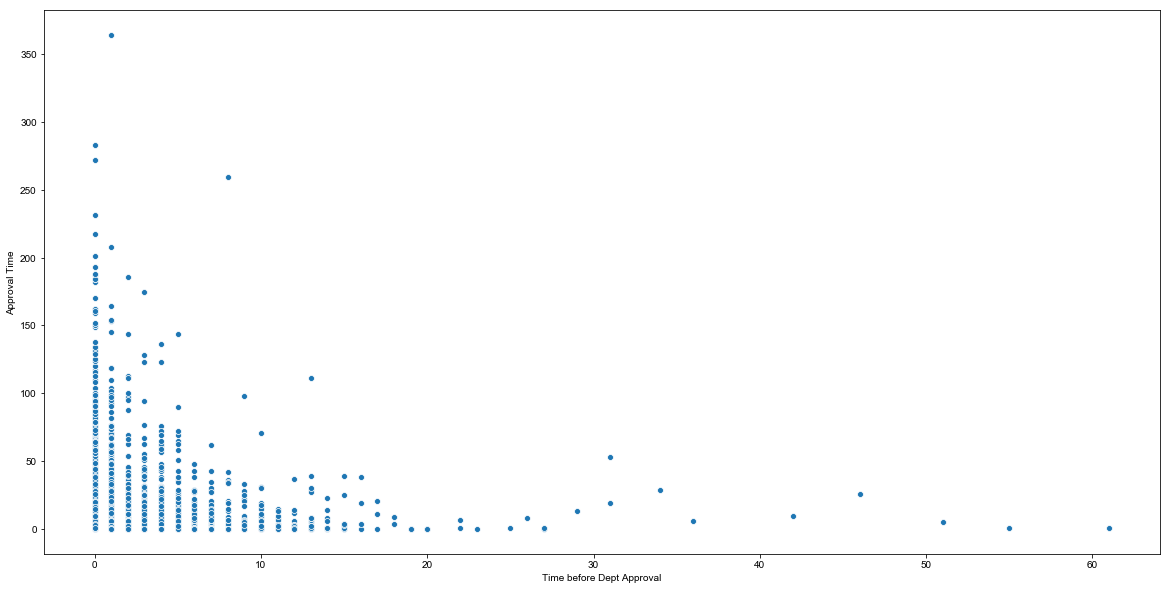

In [8]:
# Time before dept approval time by approval time
fig, ax = plt.subplots(figsize=(20,10))
ax = sns.scatterplot(x="Time before Dept Approval", y="Approval Time", data=Data)

It seems that orders that are quickly submitted take longer than orders that were submitted after a decent lag period within the department where the order was drafted. This could mean that orders that were rushed are not providing all the necessary information for buyers to process.

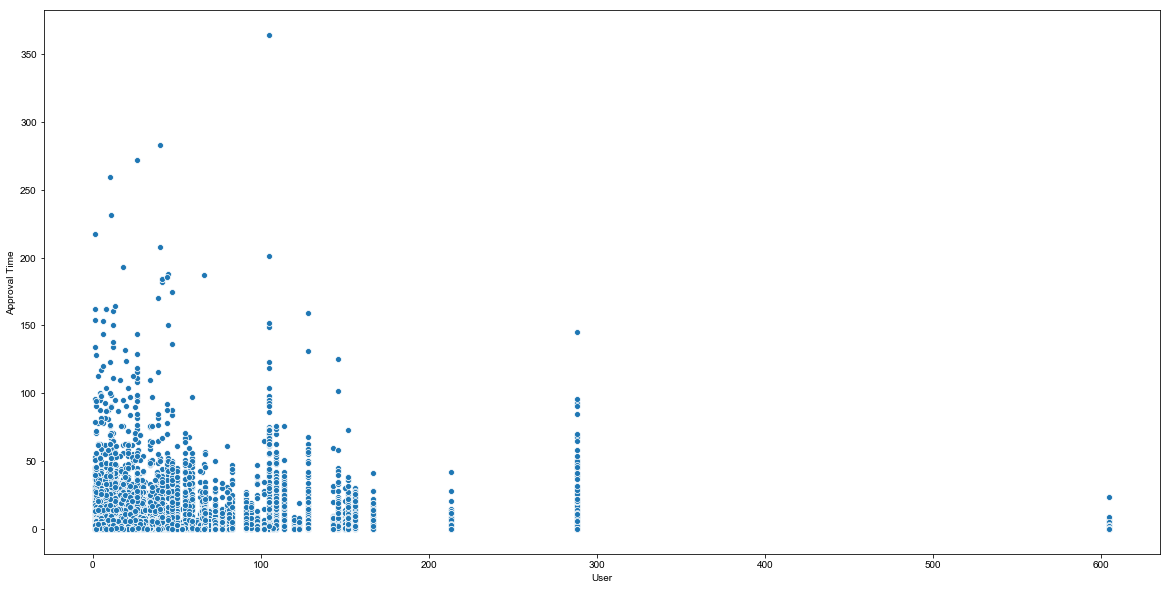

In [9]:
# User experience by approval time
fig, ax = plt.subplots(figsize=(20,10))
ax = sns.scatterplot(x="User", y="Approval Time", data=Data)

It looks like more experienced users that submit orders require less time to approve.

Now, I want to take a look at the impact that the form types will have on approval times. For each form type, I take a look at the average time to complete an order as well as how many samples we have for each form type.

[Text(0,0,'Amount-based PO'),
 Text(0,0,'Facility Rental'),
 Text(0,0,'Equipment Lease/Loan/Purchase'),
 Text(0,0,'Professional Services/Independent Consulting'),
 Text(0,0,'Non Catalog'),
 Text(0,0,'Catalog'),
 Text(0,0,'Software and Cloud Computing'),
 Text(0,0,'After the Fact'),
 Text(0,0,'Payment Request'),
 Text(0,0,'Controlled Substance'),
 Text(0,0,'Relocation/Household Moves'),
 Text(0,0,'Meeting and Entertainment Payment Request'),
 Text(0,0,'Standing Order Amount Based')]

[Text(0,0,'Amount-based PO'),
 Text(0,0,'Facility Rental'),
 Text(0,0,'Equipment Lease/Loan/Purchase'),
 Text(0,0,'Professional Services/Independent Consulting'),
 Text(0,0,'Non Catalog'),
 Text(0,0,'Catalog'),
 Text(0,0,'Software and Cloud Computing'),
 Text(0,0,'After the Fact'),
 Text(0,0,'Payment Request'),
 Text(0,0,'Controlled Substance'),
 Text(0,0,'Relocation/Household Moves'),
 Text(0,0,'Meeting and Entertainment Payment Request'),
 Text(0,0,'Standing Order Amount Based')]

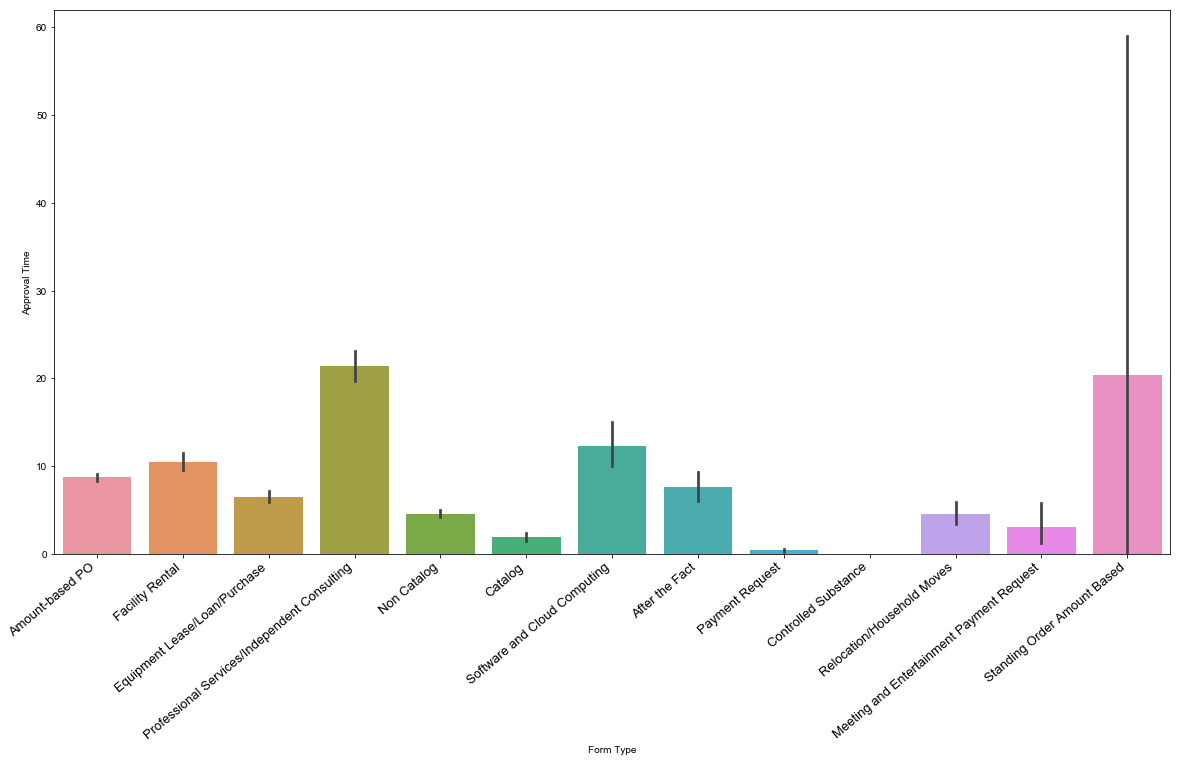

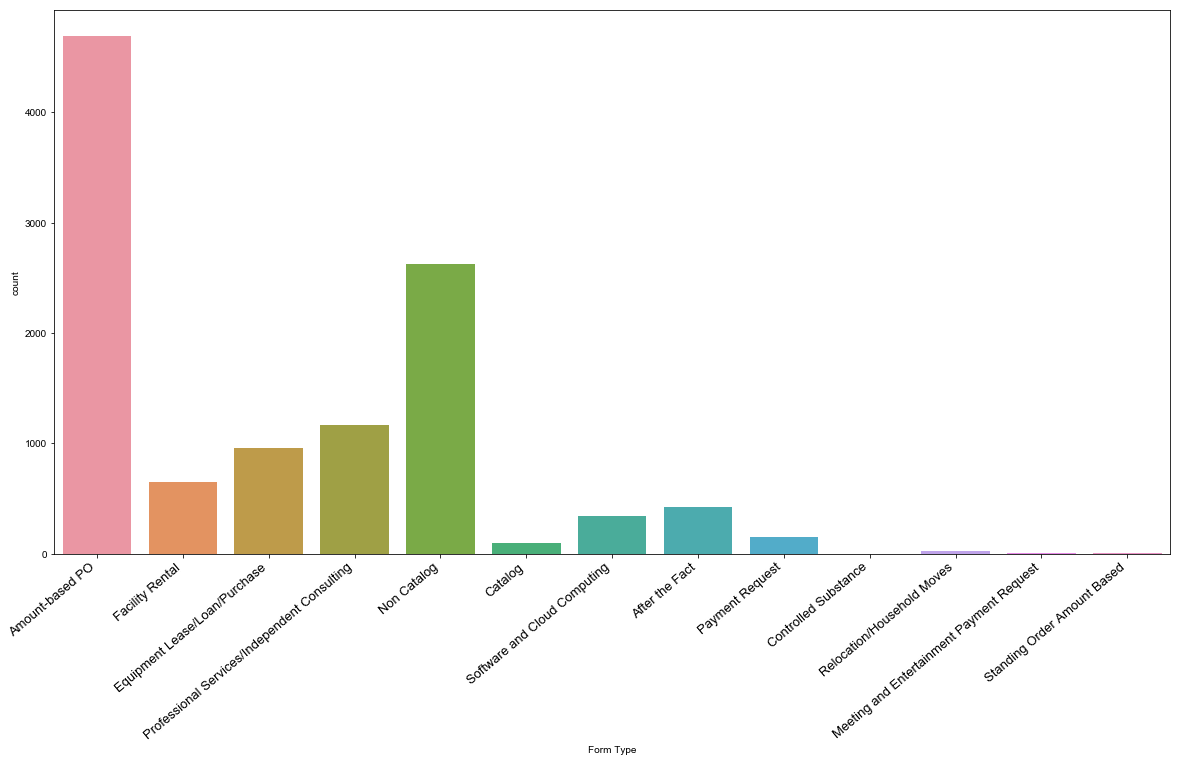

In [10]:
# Plot average approval time for each form type
fig, ax = plt.subplots(figsize=(20,10))
ax = sns.barplot(x='Form Type', y='Approval Time', data=Data)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right", fontsize=13)

# Plot amount of orders for each form type
fig, ax = plt.subplots(figsize=(20,10))
ax = sns.countplot(x='Form Type', data=Data)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right", fontsize=13)

It's apparent that some forms take longer than others. For the forms with many samples, we may end up with better estimates.

Now, I examine the differences between the different buyers to see if there is any difference in completion time.

[Text(0,0,'Rosemarie Hughes'),
 Text(0,0,'Robert Puerzer'),
 Text(0,0,'Byron Wilson'),
 Text(0,0,'Tyrone Webb'),
 Text(0,0,'Timothy Alt Jr.'),
 Text(0,0,'Jose Padilla Nunez'),
 Text(0,0,'Josie Ip'),
 Text(0,0,'Christina Morache'),
 Text(0,0,'Tanya Krupsky'),
 Text(0,0,'Daisy Palma'),
 Text(0,0,'Kenya Stafford'),
 Text(0,0,'Joel Ross'),
 Text(0,0,'Maria Mazzei'),
 Text(0,0,'Sandra Rahman'),
 Text(0,0,'Keith Muller'),
 Text(0,0,'Bernadette Jimenez'),
 Text(0,0,'Dianne Holmes'),
 Text(0,0,'Paul Mulligan'),
 Text(0,0,'Gaynell Celestine')]

[Text(0,0,'Rosemarie Hughes'),
 Text(0,0,'Robert Puerzer'),
 Text(0,0,'Byron Wilson'),
 Text(0,0,'Tyrone Webb'),
 Text(0,0,'Timothy Alt Jr.'),
 Text(0,0,'Jose Padilla Nunez'),
 Text(0,0,'Josie Ip'),
 Text(0,0,'Christina Morache'),
 Text(0,0,'Tanya Krupsky'),
 Text(0,0,'Daisy Palma'),
 Text(0,0,'Kenya Stafford'),
 Text(0,0,'Joel Ross'),
 Text(0,0,'Maria Mazzei'),
 Text(0,0,'Sandra Rahman'),
 Text(0,0,'Keith Muller'),
 Text(0,0,'Bernadette Jimenez'),
 Text(0,0,'Dianne Holmes'),
 Text(0,0,'Paul Mulligan'),
 Text(0,0,'Gaynell Celestine')]

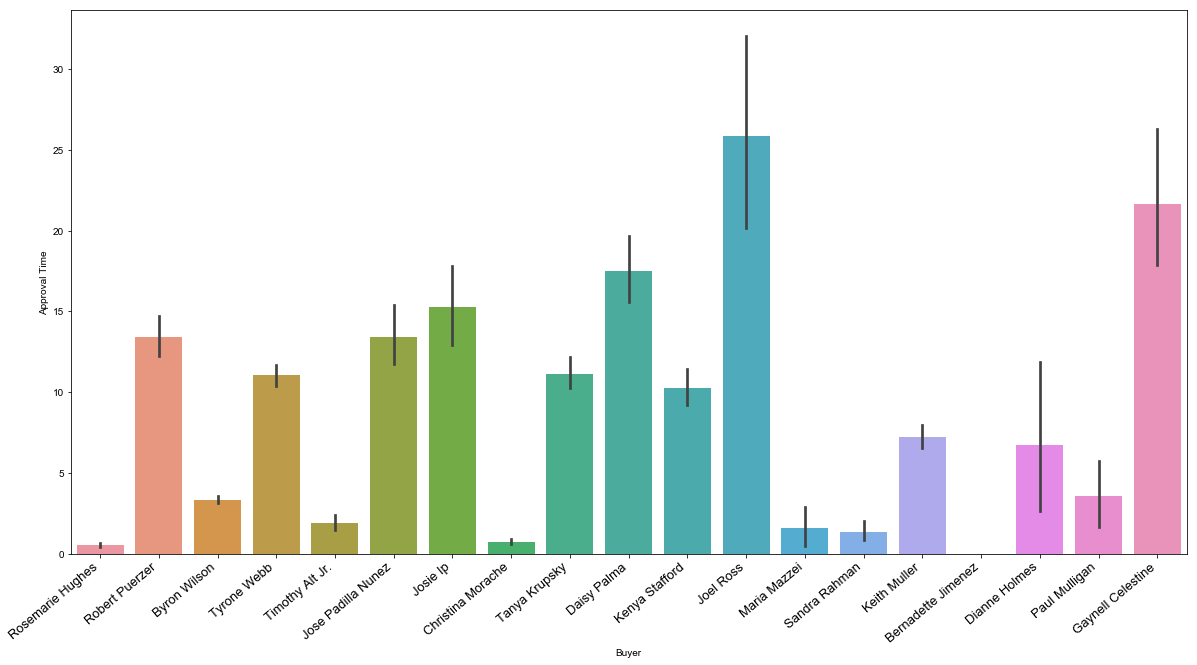

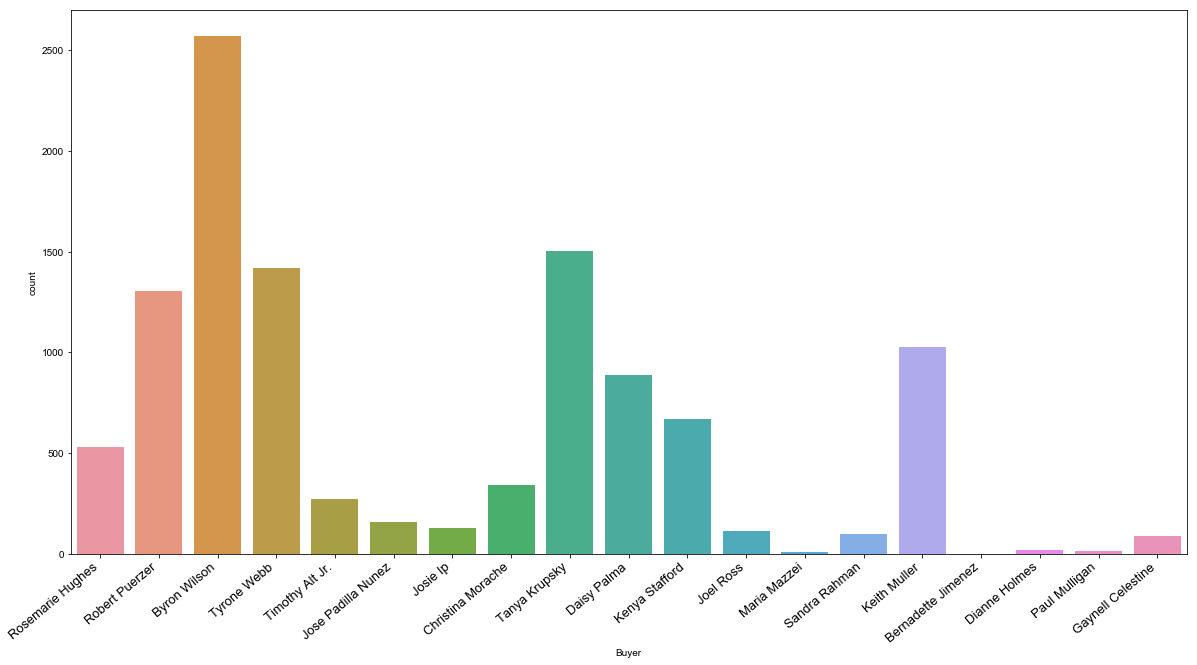

In [11]:
# Average buyer approval times
fig, ax = plt.subplots(figsize=(20,10))
ax = sns.barplot(x='Buyer', y='Approval Time', data=Data)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right", fontsize=13)

# Data points for each buyer
fig, ax = plt.subplots(figsize=(20,10))
ax = sns.countplot(x='Buyer', data=Data)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right", fontsize=13)

The way buyers are set up within Supply Chain Management, each buyer is assigned to a different set of departments who all have different ordering needs. Some buyers may need to approve more orders for departments for professional services, which is the category that seems to take the longest amount of time to approve on average. To explore this a bit more, I want to take a look at the distribution of form types for each buyer.

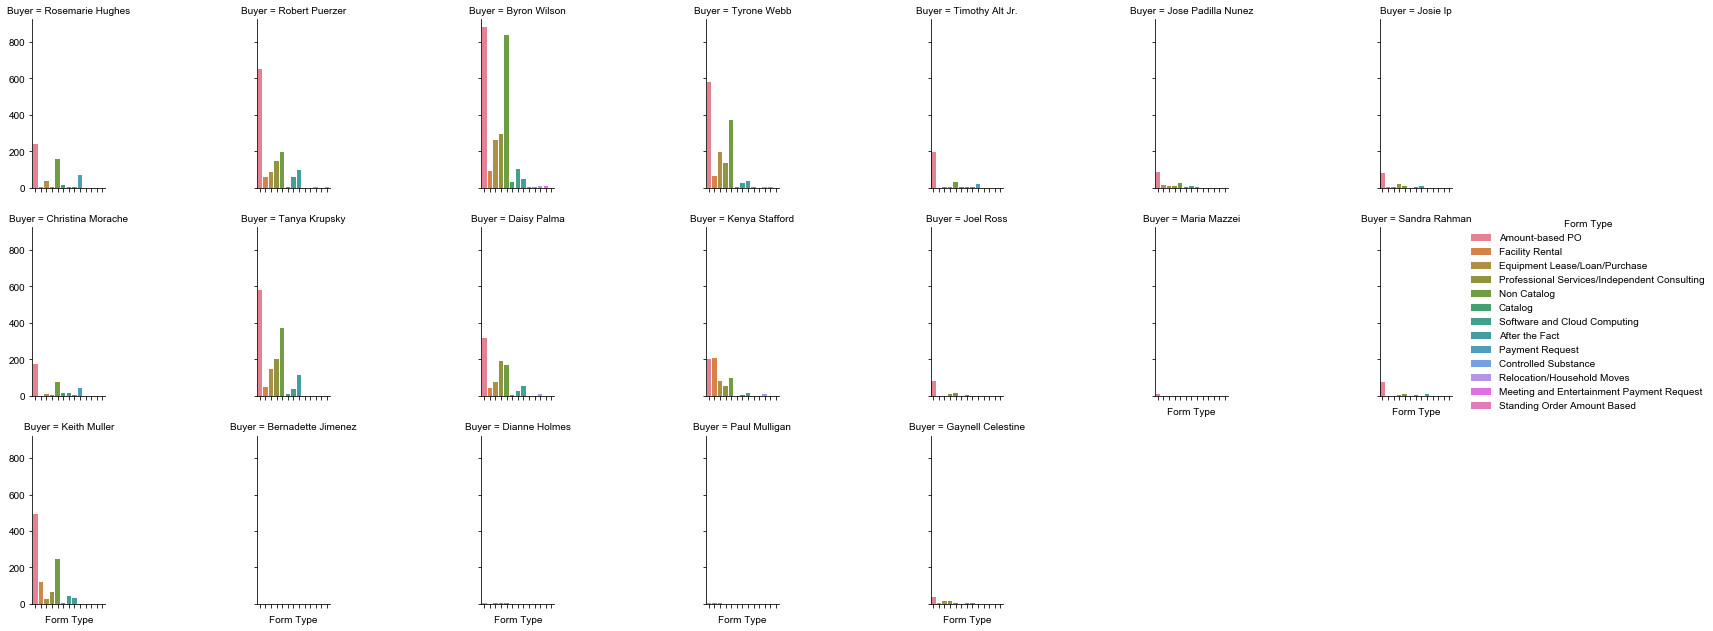

In [12]:
# Make a count plot for each buyer to show the counts for each form type
g = sns.FacetGrid(Data, col='Buyer', hue='Form Type', col_wrap=7)
g.map(sns.countplot,'Form Type',order=Data['Form Type'].unique())
g.add_legend();
g.set(xticklabels=[])

Visually, we can see that the distribution of orders for each buyer is roughly the same shape. As a buyer has more orders, it seems that they recieve the biggest increases in Amount-based POs and Non-Catalog type orders. Also, Pulaski seems to  get almost twice as many Facility Rental orders as the other buyers, but less of other types of orders.
### Data Analysis Summary
To summarize what I learned about the data:
* Larger orders with higher spending does not necessarily mean that the order will take longer to approve, even if there are more regulations and approvers that are part of the process. In fact, smaller order can take longer to approve.
* The amount of time it takes a department to submit an order has a similar relationship to approval time as order size. This could be a signal that rushed orders can cause more complications, or that other factors are more important.
* Some form types are very uncommon and may be difficult to estimate based on the number of samples we have in our dataset if form type happens to be an important feature.
* Buyers have a varied average approval time which signals that buyers handle orders differently, especially since they seem to receive a similar distribution of orders by form type.

## Model Testing

Looking at this data set, we have three categorical fields: Requester, Form Type, and Buyer. For these fields to be processed using the sci-kit learn module, they need to be represented numerically. A common approach to solving this issue is to give each category in the field a new column for which the value is either 0 or 1. 0 would indicate that the value is present in the row of data, whereas 1 would indicate that the value is not present. The issue with this approach is that we may have some categorical fields that have too many categories, which would create too many columns. So before proceeding, I checked to see how many unique values are in each category.

In [13]:
Data['Form Type'].nunique()
Data['Buyer'].nunique()

13

19

The Buyer and Form Type fields can be easily split into individual dummy columns correspoding to each category and then labeled as a 1 or 0 (present or not present). However, the Requester column has too many categories and needs to be encoded using a different method.

Thinking about the Requester column, the reason we are adding this metric into our model is so that our model takes into account the requester's experience level with the ordering process. Another way we can assess the requester's experience level is to count the total transactions that they have submitted. If the same person has gone through the process multiple times, they may get better at submitting the necessary regulatory information on the first attempt.

In [14]:
df = pd.get_dummies(Data, columns=['Form Type','Buyer'])

# Split data 80/20 for training and testing
train, test = train_test_split(df, test_size=0.2, random_state=44)

# Split the training data on the features x and labels y
x_train = train[train.columns.difference(['Approval Time'])]
y_train = train['Approval Time']

# Split out the testing data on the features x and labels y
x_test = test[test.columns.difference(['Approval Time'])]
y_test = test['Approval Time']

Apply various regression models and evaluate to find which models are working best.

In [15]:
# Find the p-values of the coefficients to determine which features are not having much impact on the model

X2 = sm.add_constant(x_train)
est = sm.OLS(y_train, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:          Approval Time   R-squared:                       0.163
Model:                            OLS   Adj. R-squared:                  0.160
Method:                 Least Squares   F-statistic:                     52.40
Date:                Fri, 21 Jun 2019   Prob (F-statistic):          3.29e-312
Time:                        11:51:17   Log-Likelihood:                -37363.
No. Observations:                8920   AIC:                         7.479e+04
Df Residuals:                    8886   BIC:                         7.503e+04
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
                                                             coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------

C:\Users\kpanfilov\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:52: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return getattr(obj, method)(*args, **kwds)


In [16]:
ridgeReg = Ridge(alpha=.25, normalize=True)
ridgeReg.fit(x_train,y_train)
print('Ridge R^2:', ridgeReg.score(x_test, y_test))

lassoReg = Lasso(alpha=.05, normalize=True)
lassoReg.fit(x_train,y_train)
print('Lasso R^2:', lassoReg.score(x_test, y_test))

ENreg = ElasticNet(alpha=.5, l1_ratio=1, normalize=True)
ENreg.fit(x_train,y_train)
print('Elastic Net R^2:', ENreg.score(x_test, y_test))

# Create a decision tree to fit the data with a maximum depth of 15
# to prevent overfitting.
Tree = tree.DecisionTreeRegressor(max_depth=5,min_samples_leaf=40).fit(x_train,y_train)
print('DTree R^2:', Tree.score(x_test, y_test))

# Create a random forest of decision trees 
RandTree = RandomForestRegressor(n_estimators=70,max_depth=10,min_samples_leaf=15,min_samples_split=3).fit(x_train,y_train)
print('RandDTree R^2:', RandTree.score(x_test, y_test))

Ridge(alpha=0.25, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=True, random_state=None, solver='auto', tol=0.001)

Ridge R^2: 0.14708589503918468


Lasso(alpha=0.05, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=True, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

Lasso R^2: -0.0013493083087665614


ElasticNet(alpha=0.5, copy_X=True, fit_intercept=True, l1_ratio=1,
      max_iter=1000, normalize=True, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

Elastic Net R^2: -0.0013493083087665614
DTree R^2: 0.13476923260687834
RandDTree R^2: 0.20297690918976508


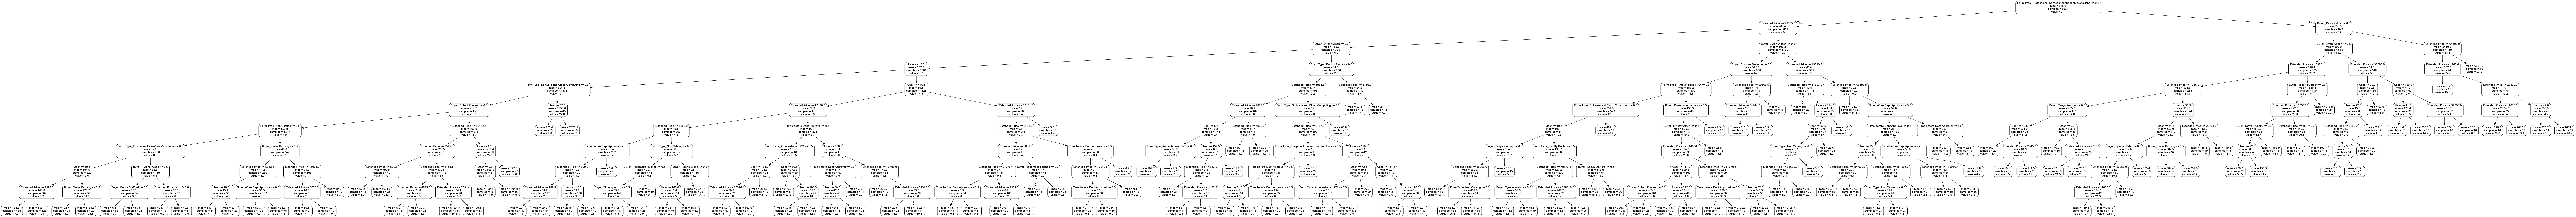

In [17]:
# Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot
# Pull out one tree from the forest
tree = RandTree.estimators_[5]
# Export the image to a dot file
export_graphviz(tree, out_file = 'tree.dot', feature_names=list(x_train), rounded = True, precision = 1)
# Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('tree.dot')
# Write graph to a png file
graph.write_png('tree.png')

# Output the image
from IPython.display import Image
Image(filename='tree.png') 

## Make Updates
Even our best attempt using a random forest only yeilds an R squared of about .2, which is not ideal. In order to produce a better model, I will try a combination of two things. First, I re-evaluate the problem to see if we can simplify the issue to the point where we don't need to predict exactly how much time it will take to complete an order. For instance, we may just want to identify if it will be a difficult order or not. Additionally, as with any machine learning problem, the model is only as good as the features that are used so I will try to add some more features that may relate to approval times.

### Set Approval Time Median

In [18]:
Data['Approval Time'].median()
Data['Approval Time'].mean()

3.0

8.850941704035874

In [19]:
Data['Approval'] = Data['Approval Time'].apply(lambda x: 0 if x < 4 else 1)

In [20]:
Data.head()

,Form Type,Time before Dept Approval,Extended Price,Buyer,Approval Time,User,Approval
1,Amount-based PO,3.0,269753.27,Rosemarie Hughes,1.0,16,0
2,Facility Rental,1.0,1250992.00,Robert Puerzer,16.0,288,1
3,Equipment Lease/Loan/Purchase,0.0,929012.16,Byron Wilson,1.0,30,0
4,Amount-based PO,0.0,55000.00,Tyrone Webb,0.0,31,0
5,Professional Services/Independent Consulting,0.0,90000.00,Tyrone Webb,35.0,31,1


In [21]:
xf = pd.get_dummies(Data, columns=['Form Type','Buyer']).drop(columns='Approval Time')

# Split data 80/20 for training and testing
train, test = train_test_split(xf, test_size=0.2, random_state=44)

# Split the training data on the features x and labels y
x_train = train[train.columns.difference(['Approval'])]
y_train = train['Approval']

# Split out the testing data on the features x and labels y
x_test = test[test.columns.difference(['Approval'])]
y_test = test['Approval']

In [22]:
from sklearn.linear_model import LogisticRegression
logReg = LogisticRegression().fit(x_train,y_train)
print('LogReg Score:', logReg.score(x_test, y_test))

LogReg Score: 0.5748878923766816


In [23]:
logReg.predict_proba(test.drop(columns='Approval'))

array([[9.99888751e-01, 1.11249089e-04],
       [1.00000000e+00, 1.35130737e-11],
       [9.85448770e-01, 1.45512302e-02],
       ...,
       [9.99999999e-01, 5.42638734e-10],
       [9.99999993e-01, 6.95385128e-09],
       [1.00000000e+00, 3.41737351e-43]])

In [24]:
predict = test
predict['predict'] = logReg.predict(test.drop(columns='Approval'))
predict.loc[predict['predict'] == 1]

,Time before Dept Approval,Extended Price,User,Approval,Form Type_After the Fact,Form Type_Amount-based PO,Form Type_Catalog,Form Type_Controlled Substance,Form Type_Equipment Lease/Loan/Purchase,Form Type_Facility Rental,...,Buyer_Kenya Stafford,Buyer_Maria Mazzei,Buyer_Paul Mulligan,Buyer_Robert Puerzer,Buyer_Rosemarie Hughes,Buyer_Sandra Rahman,Buyer_Tanya Krupsky,Buyer_Timothy Alt Jr.,Buyer_Tyrone Webb,predict
